In [1]:
import numpy as np
import h5py
import math
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import torch
import random
import torch.nn as nn
import sklearn
import collections
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import json
from torch.optim import Adam
import pylab
from scipy.optimize import curve_fit
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.insert(0,'/content/gdrive/MyDrive/Penn/Colab/Data/')
from functions import load_model, save_model, Dataset, Trainer, mse_loss
from sklearn.metrics import roc_curve, auc

Mounted at /content/gdrive


## Load Data

In [2]:
# Load Background data, which will be used for training
filename = 'BKG_dataset.h5'
with h5py.File('/content/gdrive/MyDrive/Penn/Colab/Data/BKG_dataset.h5', 'r') as file:
    X_train = np.array(file['X_train'])
    X_test = np.array(file['X_test'])
    X_val = np.array(file['X_val'])

print(X_train.shape)

X_train = np.reshape(X_train, (-1, 19,3,1))
X_test = np.reshape(X_test, (-1, 19,3,1))
X_val = np.reshape(X_val, (-1, 19,3,1))

print(X_train.shape)

(640000, 57)
(640000, 19, 3, 1)


In [3]:
BATCH_SIZE = 1024

In [4]:
# Initialize datasets
train_dataset = Dataset(X=X_train, y=X_train)
test_dataset = Dataset(X=X_test, y=X_test)
val_dataset = Dataset(X=X_val, y=X_val)

In [5]:
# Initialize dataloaders
train_loader = train_dataset.create_dataloader(batch_size=BATCH_SIZE, shuffle=True)
test_loader = test_dataset.create_dataloader(batch_size=BATCH_SIZE, shuffle=False)
val_loader = val_dataset.create_dataloader(batch_size=BATCH_SIZE, shuffle=False)
batch_X, batch_y = next(iter(train_loader))
print ("Sample batch:\n"
    f"  X: {list(batch_X.size())}\n"
    f"  y: {list(batch_y.size())}\n")

Sample batch:
  X: [1024, 19, 3, 1]
  y: [1024, 19, 3, 1]



/content/gdrive/MyDrive/Penn/Colab/Data/functions.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(sample[0]).float() for sample in batch]
/content/gdrive/MyDrive/Penn/Colab/Data/functions.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = [torch.tensor(sample[1]).float() for sample in batch]


## CNN and Trainer Classes

In [6]:
class CNN_VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_filters):
        """input_dim: array of the dimensions: [N, H, W, C]
        latent_dim: dimension of the latent space."""

        super(CNN_VAE, self).__init__()

        self.num_filters = num_filters
        self.input_dim = input_dim

        # Encoder layers
        self.conv1 = nn.Conv2d(input_dim[-1], self.num_filters, kernel_size=(3, 3), bias=False)
        self.avg_pool = nn.AvgPool2d(kernel_size=(2, 1))
        self.batch_norm1 = nn.BatchNorm2d(self.num_filters)
        self.fc_mean = nn.Linear((self.input_dim[1]//2)*self.input_dim[2]*self.num_filters, latent_dim)
        self.fc_logvar = nn.Linear((self.input_dim[1]//2)*self.input_dim[2]*self.num_filters, latent_dim)


        # Decoder layers
        self.fc1 = nn.Linear(latent_dim, (self.input_dim[1]//2)*self.input_dim[2]*self.num_filters)
        self.up_sample = nn.Upsample(scale_factor=(2, 1))
        self.zpad = nn.ZeroPad2d((0, 0, 1, 0))
        self.conv2 = nn.Conv2d(self.num_filters, self.input_dim[-1], kernel_size=(3, 3), bias=False)
        self.batch_norm2 = nn.BatchNorm2d(self.input_dim[-1])



    def forward(self, x_in):
        """Forward through the autoencoder with relu activation."""

        # Encoder
        x_in = (x_in.transpose(1, 3)).transpose(2, 3) # Transpose input [N, H, W, C] ==> [N, C, H, W]
        z = F.pad(x_in, pad=(1, 1, 1, 1)) # SAME padding to conserve dimensions
        z = self.conv1(z)
        z = self.avg_pool(z)
        z = self.batch_norm1(z)
        z = F.relu(torch.flatten(z, start_dim=1)) # Flatten tensor for dense layer
        mean = self.fc_mean(z)
        logvar = self.fc_logvar(z)

        # Reparameterization
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + eps*std

        # Decoder
        z = F.relu(self.fc1(z))
        z = torch.reshape(z, (-1, self.num_filters, self.input_dim[1]//2, self.input_dim[2]))
        z = self.up_sample(z)
        z = self.zpad(z)
        z = F.pad(z, pad=(1, 1, 1, 1)) # SAME padding to conserve dimensions
        z = self.conv2(z)
        z = F.relu(self.batch_norm2(z))
        z = (z.transpose(2, 3)).transpose(1, 3) # Transpose input [N, C, H, W] ==> [N, H, W, C]
        return z, mean, logvar

    def loss_function(self, x, y, mu, logvar, beta=0.42):
        """Compute the VAE loss. Beta was calculated to be roughly 0.4 for equal
        contribution of mse and kl loss terms."""
        # Reconstruction loss (MSE)
        mask = (y != 0)
        recon_loss = F.mse_loss(mask*x, mask*y, reduction='mean')

        # KL divergence loss
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

        # Total loss
        loss = (1 - beta)*recon_loss + beta*kl_loss
        return loss

In [7]:
# Define a class which will handle training and testing the model
class Trainer(object):
    def __init__(self, model, num_batches_avg, loss_fn=None, optimizer=None, scheduler=None):
        """num_batches_avg: Number of batches to calculate the average loss over.
        example: if there are 625 batches, we might want to use 25, to calculate
        average loss over 25 batches."""

        #Set params
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.num_batches_avg = num_batches_avg

    def train_step(self, dataloader):
        """Train for one epoch.

        returns: average loss over most recent {num_batches_avg} batches, loss over most recent batch
        """

        self.model.train()
        current_loss = 0.0 # Average loss of most recent batch
        avg_loss = 0.0 # Average loss over a certain number of batches
        running_loss = 0.0

        # Iterate over batches in dataloader
        for i, batch in enumerate(dataloader):

            # Pass a single batch through the model and update the weights
            inputs, targets = batch
            self.optimizer.zero_grad()
            outputs, mu, logvar = self.model(inputs)
            loss = self.loss_fn(outputs, targets, mu, logvar)
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()

            # Update loss metrics
            running_loss += loss.item()
            current_loss = loss.item()

            # Calculate the average loss
            if i % self.num_batches_avg == self.num_batches_avg - 1:
                avg_loss = running_loss / self.num_batches_avg
                running_loss = 0.0

        return avg_loss, current_loss

    def eval_step(self, dataloader):
        """validation or test step over one epoch."""

        self.model.eval()
        current_loss = 0.0 # Average loss of most recent batch
        avg_loss = 0.0 # Average loss over a certain number of batches
        running_loss = 0.0
        y_trues, model_outputs = [], []

        # Iterate over val batches
        with torch.no_grad():
            for i, batch in enumerate(dataloader):

                # Pass a single batch through the model
                inputs, y_true = batch
                outputs, mu, logvar = self.model(inputs)
                loss = self.loss_fn(outputs, y_true, mu, logvar)

                # Update loss metrics
                running_loss += loss.item()
                current_loss = loss.item()

                # Calculate the average loss
                if i % self.num_batches_avg == self.num_batches_avg - 1:
                    avg_loss = running_loss / self.num_batches_avg
                    running_loss = 0.0

                # Store outputs
                y_trues.extend(y_true)
                model_outputs.extend(outputs)
        return avg_loss, current_loss, np.vstack(y_trues), np.vstack(model_outputs)

    def predict_step(self, dataloader):
        """Prediction step."""
        self.model.eval()
        model_outputs = []

        # Iterate over batches
        with torch.no_grad():
            for i, batch in enumerate(dataloader):

                # Pass a single batch through the model
                inputs, targets = batch
                outputs, mu , logvar = self.model(inputs)

                # Store outputs
                model_outputs.extend(outputs)

        return np.vstack(model_outputs), np.vstack(mu), np.vstack(logvar)

    def train(self, num_epochs, patience, train_dataloader, val_dataloader):
        """Train the neural net."""

        best_val_loss = np.inf
        patience_counter=patience

        # Loop over epochs
        for epoch in range(num_epochs):

            # Steps
            avg_train_loss, last_train_loss = self.train_step(dataloader=train_dataloader)
            avg_val_loss, last_val_loss, _, _ = self.eval_step(dataloader=val_dataloader)
            self.scheduler.step(avg_val_loss)

            # Early stopping
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model = self.model
                patience_counter = patience # reset patience
            else:
                patience_counter -= 1
            if not patience_counter: # 0
                print("Stoping Early!")
                break

            # Logging
            print(f'Epoch: {epoch+1} | '
            f'average train loss over most recent {self.num_batches_avg} batches: {avg_train_loss},'
            f'average val loss over most recent {self.num_batches_avg} batches: {avg_val_loss},'
            #f'learning rate: {self.optimizer.param_groups[0]['lr']:.2E},'
            f'patience counter: {patience_counter}')

        return best_model

## Initialize Model and Train

In [8]:
# Define consts
LEARNING_RATE = 1e-3
PATIENCE = 6
NUM_EPOCHS = 30

In [9]:
# Initialize model
INPUT_DIM = X_train.shape
NUM_FILTERS = 10
LATENT_DIM = 8
conv_VAE = CNN_VAE(input_dim=INPUT_DIM, latent_dim=LATENT_DIM, num_filters=NUM_FILTERS)
print(conv_VAE.named_parameters)

<bound method Module.named_parameters of CNN_VAE(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (avg_pool): AvgPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0)
  (batch_norm1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_mean): Linear(in_features=270, out_features=3, bias=True)
  (fc_logvar): Linear(in_features=270, out_features=3, bias=True)
  (fc1): Linear(in_features=3, out_features=270, bias=True)
  (up_sample): Upsample(scale_factor=(2.0, 1.0), mode='nearest')
  (zpad): ZeroPad2d((0, 0, 1, 0))
  (conv2): Conv2d(10, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (batch_norm2): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)>


In [10]:
# Initialize the loss function, optimizer and lr scheduler, trainer
def loss_fn(x, y, mu, logvar):
    return conv_VAE.loss_function(x, y, mu, logvar)
optimizer = Adam(params=conv_VAE.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.2, patience=3, verbose=True)
trainer = Trainer(model=conv_VAE, num_batches_avg=25,
                  loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler)

In [11]:
# Train
best_model = trainer.train(
    num_epochs=NUM_EPOCHS, patience=PATIENCE,
    train_dataloader=train_loader, val_dataloader=val_loader)

Epoch: 1 | average train loss over most recent 25 batches: 34.36308433532715,average val loss over most recent 25 batches: 34.061472778320315,patience counter: 6
Epoch: 2 | average train loss over most recent 25 batches: 29.908897094726562,average val loss over most recent 25 batches: 28.46600311279297,patience counter: 6
Epoch: 3 | average train loss over most recent 25 batches: 23.311505432128907,average val loss over most recent 25 batches: 23.649886322021484,patience counter: 6
Epoch: 4 | average train loss over most recent 25 batches: 18.759357986450194,average val loss over most recent 25 batches: 18.672911987304687,patience counter: 6
Epoch: 5 | average train loss over most recent 25 batches: 14.905845565795898,average val loss over most recent 25 batches: 14.95129695892334,patience counter: 6
Epoch: 6 | average train loss over most recent 25 batches: 12.033467826843262,average val loss over most recent 25 batches: 12.267050056457519,patience counter: 6
Epoch: 7 | average train 

In [12]:
# Save model
save_model(best_model, 'CNN_VAE_testing_1')

In [13]:
# Load model
conv_VAE = CNN_VAE(input_dim=INPUT_DIM, latent_dim=LATENT_DIM, num_filters=NUM_FILTERS)
conv_VAE = load_model(conv_VAE, 'CNN_VAE_testing_1')
trainer = Trainer(model=conv_VAE, num_batches_avg=25,
                  loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler)

In [14]:
# Calculate the appropriate beta value for loss function
# (We want the mse and kl loss terms to be roughly equal contributions)

outputs, mu, logvar = conv_VAE(batch_X)
mask = (batch_X != 0)
_mse_loss = F.mse_loss(mask*outputs, mask*batch_X, reduction='mean')
kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
beta = _mse_loss / (kl_loss + _mse_loss)
print(f'mse loss: {_mse_loss}')
print(f'kl loss: {kl_loss}')
print(f'beta: {beta}')

mse loss: 0.9133915901184082
kl loss: 1.5409516096115112
beta: 0.3721531331539154


In [15]:
#bkg_prediction = trainer.predict_step(dataloader=test_loader)
bkg_prediction, bkg_mu, bkg_logvar = conv_VAE(torch.tensor(X_test, requires_grad=False).float())
bkg_prediction = bkg_prediction.detach().numpy()

In [16]:
# add correct signal labels
signal_labels = ['Ato4l', 'hChToTauNu', 'hToTauTau', 'leptoquark']

In [17]:
# add correct path to signal files
drive_path = '/content/gdrive/MyDrive/Penn/Colab/Data/'
signals_file = [drive_path+label+'_dataset.h5' for label in signal_labels]
print(signals_file)

['/content/gdrive/MyDrive/Penn/Colab/Data/Ato4l_dataset.h5', '/content/gdrive/MyDrive/Penn/Colab/Data/hChToTauNu_dataset.h5', '/content/gdrive/MyDrive/Penn/Colab/Data/hToTauTau_dataset.h5', '/content/gdrive/MyDrive/Penn/Colab/Data/leptoquark_dataset.h5']


In [18]:
# read signal data
signal_data = []
for i, label in enumerate(signal_labels):
    with h5py.File(signals_file[i], 'r') as file:
        test_data = np.array(file[label])
    test_data = np.reshape(test_data, (-1, 19, 3, 1))
    signal_data.append(test_data)

print(np.array(signal_data).shape)

(4,)


<ipython-input-18-c5d333d51caa>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(signal_data).shape)


In [19]:
signal_results = []
sig_mu = []
sig_logvar = []

for i, label in enumerate(signal_labels):
    signal_prediction, mu, logvar = conv_VAE(torch.tensor(signal_data[i], requires_grad=False).float())
    signal_results.append([label, signal_data[i], signal_prediction]) # save [label, true, prediction] for signal
    sig_mu.append(mu)
    sig_logvar.append(logvar)

## MSE AD Score

In [20]:
def mse_loss_masked(y, x):
    mask = (y != 0)
    return mse_loss(mask*y, mask*x)

In [21]:
# compute loss value (true, predicted)
total_loss = []
total_loss.append(mse_loss_masked(np.reshape(X_test, (-1, 57)),
                           np.reshape(bkg_prediction.astype(np.float32), (-1, 57))))
for i, signal_X in enumerate(signal_data):
    total_loss.append(mse_loss_masked(np.reshape(signal_X, (-1, 57)),
                               np.reshape(signal_results[i][2].detach().numpy().astype(np.float32), (-1, 57))))

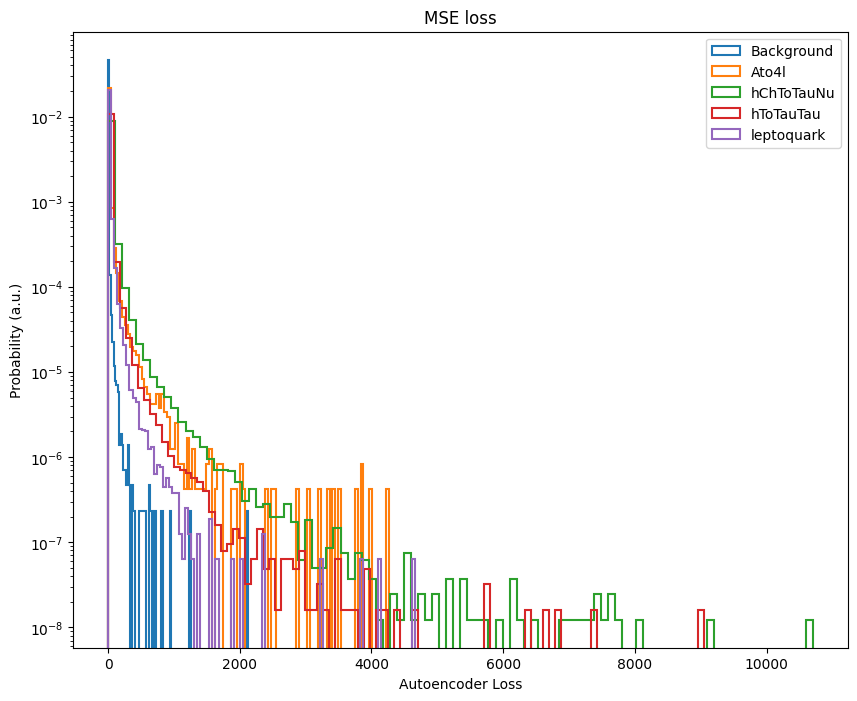

In [22]:
bin_size=100
labels = np.concatenate([['Background'], np.array(signal_labels)])
plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    plt.hist(total_loss[i], bins=bin_size, label=label, density = True, histtype='step', fill=False, linewidth=1.5)

plt.yscale('log')
plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.title('MSE loss')
plt.legend(loc='best')
plt.show()

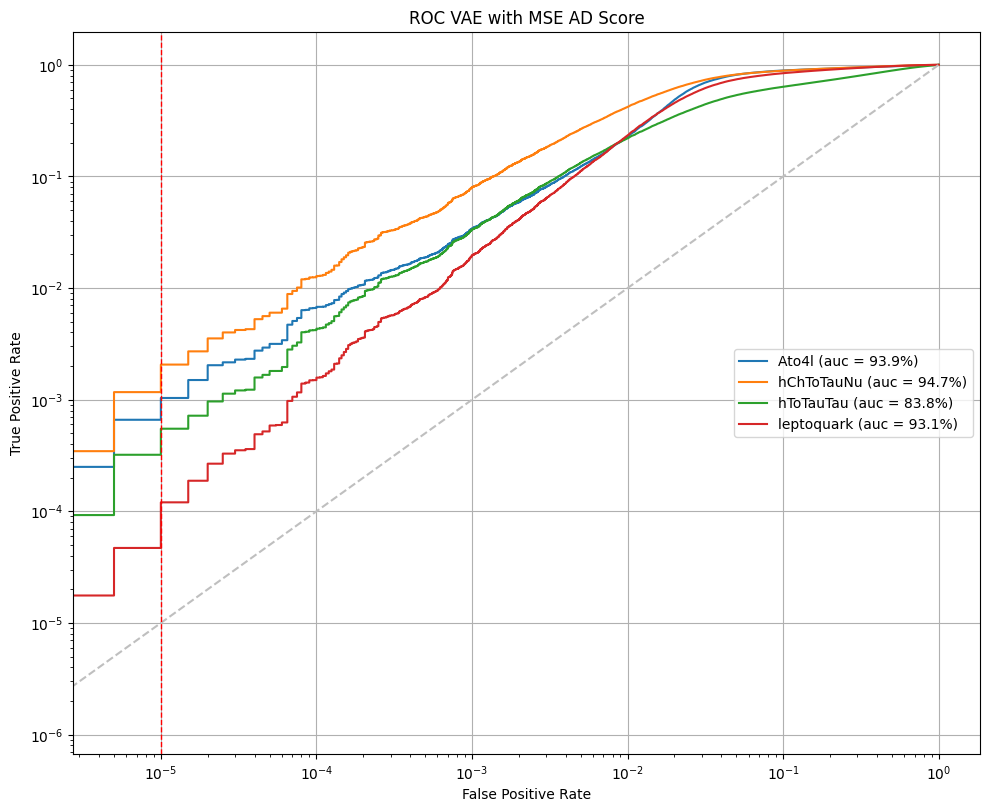

In [23]:
target_background = np.zeros(total_loss[0].shape[0])

plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    if i == 0: continue # background events

    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

    auc_loss = auc(fpr_loss, tpr_loss)

    plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)'%(label,auc_loss*100.), linewidth=1.5)

    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
plt.title("ROC VAE with MSE AD Score")
plt.show()

## KL AD Score

In [24]:
# Define AD score
def AD_score(mu, logvar):
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)

In [25]:
total_loss = []

total_loss.append(AD_score(bkg_mu, bkg_logvar).detach())
for i, signal_X in enumerate(signal_data):
    total_loss.append(AD_score(sig_mu[i], sig_logvar[i]).detach())

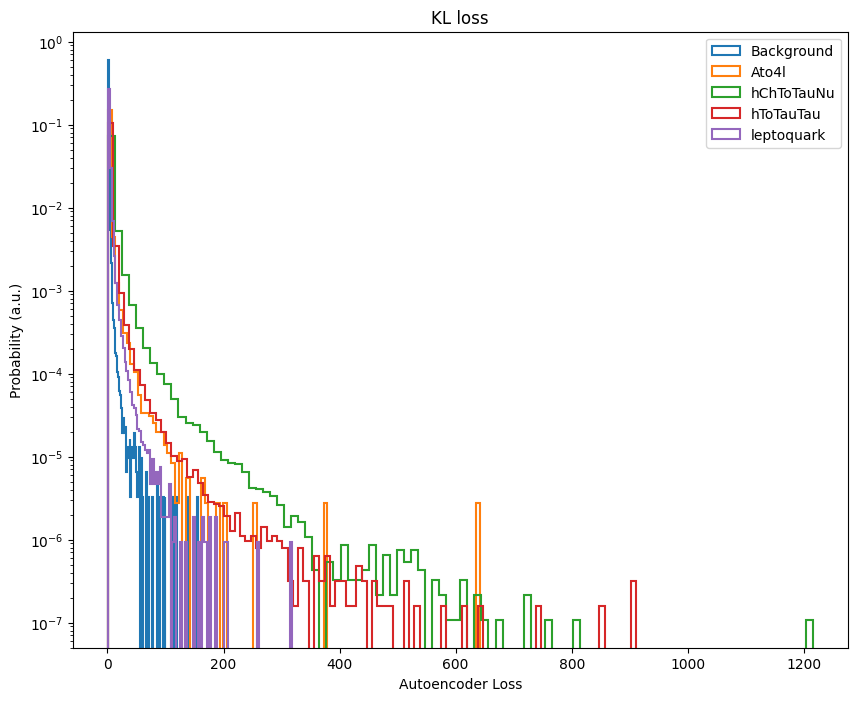

In [26]:
bin_size=100
labels = np.concatenate([['Background'], np.array(signal_labels)])
plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    plt.hist(total_loss[i], bins=bin_size, label=label, density = True, histtype='step', fill=False, linewidth=1.5)

#plt.hist(total_loss[0], bins=bin_size, label='background', density = True, histtype='step', fill=False, linewidth=1.5)
#plt.hist(total_loss[1], bins=bin_size, label='Ato4l', density = True, histtype='step', fill=False, linewidth=1.5)
plt.yscale('log')
plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.title('KL loss')
plt.legend(loc='best')
plt.show()

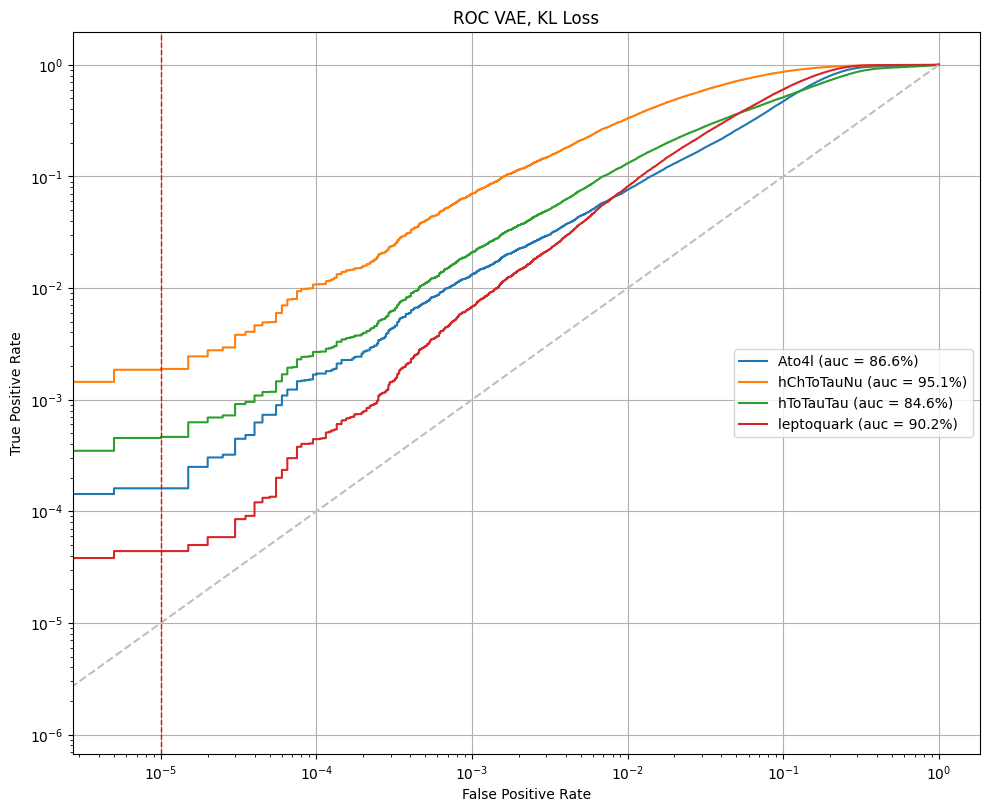

In [27]:
target_background = np.zeros(total_loss[0].shape[0])

plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    if i == 0: continue # background events

    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

    auc_loss = auc(fpr_loss, tpr_loss)

    plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)'%(label,auc_loss*100.), linewidth=1.5)

    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
plt.title("ROC VAE, KL Loss")
plt.show()

## Evaluation

In [28]:
# Set the rejection rate and calculate the fpr and tpr

REJECTION_RATE = pow(10, 4)

# Make arrays
fpr = np.zeros(len(signal_labels))
tpr = np.zeros(len(signal_labels))
rejection_rates = np.zeros(len(signal_labels))
pos_preds = np.zeros(len(signal_labels))
false_positives = np.zeros(len(signal_labels))
thresholds = np.zeros(len(signal_labels))

# Loop over labels
for i, label in enumerate(labels):
    if i == 0: continue # background events

    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss, drop_intermediate=False)

    # Loop over thresholds
    for j, threshold in enumerate(threshold_loss):
        preds = (predVal_loss >= threshold)
        rejection_rate = len(preds) / np.sum(preds) # total events / number of accepts

        # Breaking
        if rejection_rate < REJECTION_RATE:
            break

        # Update Arrays
        fpr[i-1] = fpr_loss[j]
        tpr[i-1] = tpr_loss[j]
        pos_preds[i-1] = np.sum(preds)
        rejection_rates[i-1] = rejection_rate
        thresholds[i-1] = threshold

    false_positives = np.around([_fpr * np.sum(trueVal == 0) for _fpr in fpr])

# Printing
print(f'\nrejection rates: {np.round(rejection_rates, decimals=2)}')
print(f'number of positive predictions: {pos_preds}')
print(f'number of false positives: {false_positives}')
print(f'fpr: {fpr}\n')

<ipython-input-28-15bb42f00dfc>:25: RuntimeWarning: divide by zero encountered in long_scalars
  rejection_rate = len(preds) / np.sum(preds) # total events / number of accepts
<ipython-input-28-15bb42f00dfc>:25: RuntimeWarning: divide by zero encountered in long_scalars
  rejection_rate = len(preds) / np.sum(preds) # total events / number of accepts
<ipython-input-28-15bb42f00dfc>:25: RuntimeWarning: divide by zero encountered in long_scalars
  rejection_rate = len(preds) / np.sum(preds) # total events / number of accepts



rejection rates: [10238.76 10002.83 10014.42 10010.07]
number of positive predictions: [25. 96. 89. 54.]
number of false positives: [6. 0. 0. 9.]
fpr: [3.0e-05 0.0e+00 0.0e+00 4.5e-05]



<ipython-input-28-15bb42f00dfc>:25: RuntimeWarning: divide by zero encountered in long_scalars
  rejection_rate = len(preds) / np.sum(preds) # total events / number of accepts


I define 'efficiency' as follows:

with any given rejection rate, the AE will flag X events as being anomalous. I then use some other metric to flag the same number (X) events, such as the total pT of all the objects in the event. I then calculate the number of events that were flagged by both the AE and also the other metric, which we can call the overlap. The efficiency is then defined as

efficiency = 1 - (overlap / X)

With this definition, an efficiency of 1 corresponds to no overlap, and thus the AE is picking out new events.

An efficiency of 0 corresponds to complete overlap, in which case the AE is picking out the same events as the other metric, and thus the AE is not very useful.

In [29]:
# Determine Efficiency (is high AD score strongly correlated with other variables?)

for i, label in enumerate(labels):
    if i == 0: continue # background events

    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal = 1 * (np.concatenate((total_loss[i], total_loss[0])) >= thresholds[i-1]) # True=anomaly, False=bkg
    pred_indices = np.nonzero(predVal)[0] # indices of anomaly prediction

    X = np.concatenate((signal_data[i-1], X_test)).reshape(-1, 19, 3, 1) # Data beore going through model
    pT = X[:, 1:, 0, 0]
    pT_max = np.max(pT, axis=1) # Maximum pT in each event
    pT_sum = np.sum(pT, axis=1) # Sum of the pT in each event
    pT_sum_indices = np.argsort(pT_sum)[-len(pred_indices):] # indices of events with highest total pT (same number as the number of positive predictions from the model)
    pT_max_indices = np.argsort(pT_max)[-len(pred_indices):] # indices of events with highest maximum pT (same number as the number of positive predictions from the model)


    # Efficiency
    pT_sum_eff = 1 - len(np.intersect1d(pred_indices, pT_sum_indices)) / len(pT_sum_indices)
    pT_max_eff = 1 - len(np.intersect1d(pred_indices, pT_max_indices)) / len(pT_max_indices)




    print(f'\n{label}:')
    print(f'AE efficiency for pT sum: {pT_sum_eff:.3f}')
    print(f'AE efficiency for pT max: {pT_max_eff:.3f}')


Ato4l:
AE efficiency for pT sum: 0.360
AE efficiency for pT max: 0.400

hChToTauNu:
AE efficiency for pT sum: 0.594
AE efficiency for pT max: 0.417

hToTauTau:
AE efficiency for pT sum: 0.618
AE efficiency for pT max: 0.438

leptoquark:
AE efficiency for pT sum: 0.481
AE efficiency for pT max: 0.370


In [ ]:
# Determine Efficiency (is high AD score strongly correlated with other variables?)

for i, label in enumerate(labels):
    if i == 0: continue # background events

    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal = 1 * (np.concatenate((total_loss[i], total_loss[0])) >= thresholds[i-1]) # True=anomaly, False=bkg
    pred_indices = np.nonzero(predVal)[0] # indices of anomaly prediction

    X = np.concatenate((signal_data[i-1], X_test)).reshape(-1, 19, 3, 1) # Data beore going through model
    pT_sum = np.sum(X[:, 1:, 0, 0], axis=1) # Sum of the pT in each event
    high_pT_indices = np.argsort(pT_sum)[-len(pred_indices):] # indices of the top pT events (same number as the number of positive predictions from the model)
    intersection = np.intersect1d(pred_indices, high_pT_indices)

    print(f'\n{label}:')
    print(f'number of positive AE predictions: {len(pred_indices)}')
    print(f'number of high pT predictions: {len(high_pT_indices)}')
    print(f'number of shared events: {len(intersection)}')


Ato4l:
number of positive AE predictions: 25
number of high pT predictions: 25
number of shared events: 16

hChToTauNu:
number of positive AE predictions: 96
number of high pT predictions: 96
number of shared events: 49

hToTauTau:
number of positive AE predictions: 89
number of high pT predictions: 89
number of shared events: 40

leptoquark:
number of positive AE predictions: 54
number of high pT predictions: 54
number of shared events: 30
